# Session 3: Supervised Learning — Regression  
## Modeling as Controlled Experimentation

### What a Model Actually Is

A machine learning model does NOT:
- Understand houses
- Know economics
- Reason or think

A model DOES:
- Learn statistical patterns between inputs and a target
- Minimize an error function
- Assume future data behaves like past data

Important:
> Models learn correlations, not truth.

If your data is biased, leaked, or wrong,
the model will learn the wrong thing perfectly.

---

### Supervised Learning = A Controlled Experiment

In supervised learning:
- You have input features (X)
- You have a known target (y)

Your job is to test whether patterns in X
can predict y on **new, unseen data**.

This is why modeling must be treated like an experiment.

---

### Train/Test Split (Why It Exists)

We split data into:
- **Training data** → the model learns patterns
- **Test data** → simulates the real world

Why this matters:
In production, the model will see data it has never seen before.

If test data influences training in any way,
your evaluation is invalid.

This failure is called **data leakage**.

Examples of leakage:
- Including features derived from the target
- Scaling before splitting
- Filling missing values using the full dataset
- Looking at test results while tuning decisions

Rule:
> The test set is sacred. Touch it once.

---

### Underfitting vs Overfitting (Intuition Only)

**Underfitting**
- Model is too simple
- Cannot capture real patterns
- Performs poorly on both training and test data

Example:
Predicting house prices using only the average price.

**Overfitting**
- Model is too complex
- Memorizes training data
- Performs very well on training data
- Performs poorly on test data

**Good Fit**
- Learns real signal
- Ignores noise
- Performs similarly on training and test data

Key idea:
> Generalization matters more than training performance.

---

### Why We Need Metrics

Metrics exist to answer one question:

**How wrong is the model, and in what way?**

No metric is “the best”.
Each one exposes different weaknesses.

---

### MAE — Mean Absolute Error

- Average absolute difference between predictions and true values
- Measured in the same unit as the target (e.g., dollars)
- Easy to explain to non-technical people

Interpretation:
> “On average, the model is off by X dollars.”

Strength:
- Robust and interpretable

Weakness:
- Treats all errors equally

---

### MSE — Mean Squared Error

- Squares errors before averaging
- Penalizes large mistakes heavily
- Sensitive to outliers

Interpretation:
> “Large errors are extremely bad.”

Strength:
- Useful when big mistakes are unacceptable

Weakness:
- Hard to interpret directly
- Dominated by outliers

---

### R² — Coefficient of Determination

- Measures how much variance in the target the model explains
- Compares the model to a naive baseline (predicting the mean)

Values:
- R² = 1.0 → perfect prediction
- R² = 0.0 → no better than predicting the mean
- R² < 0.0 → worse than the mean

Critical warning:
> A high R² does NOT mean a good model.
> It says nothing about bias, leakage, or real-world usefulness.

---

### Baseline Models (Non-Negotiable)

Before building any real model, build a stupid one.

Example:
- Predict the average house price for every house

If your model does NOT beat this baseline,
it is useless regardless of how advanced it looks.

---

### Feature Handling Matters

Linear regression assumes:
- Numeric inputs
- Comparable feature scales
- No fake ordering in categories

Therefore:
- Categorical features must be encoded
- Numeric features should be scaled

Bad preprocessing produces misleading coefficients.

---

### Critical Mindset for Modeling

- A model is guilty until proven useful
- Metrics without context are meaningless
- Improvement must be measured against a baseline
- Better models cannot fix bad data

If your first instinct is “try a more complex model”,
you skipped the thinking step.


In [1]:
# Session 3 — Code Cell 1
# Imports: pandas/numpy for data handling, sklearn for modeling
import pandas as pd
import numpy as np

# scikit-learn utilities for splitting data and building pipelines
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing tools
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Model
from sklearn.linear_model import LinearRegression

# Metrics (how we measure error)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv("house_prices.csv")
df.head()

,Id,Neighborhood,YearBuilt,LotArea,OverallQual,GrLivArea,FullBath,GarageCars,Fireplaces,CentralAir,KitchenQual,DistanceToCityCenterKm,SaleCondition,SalePrice
0,1,Edwards,1987,5405.0,1,1981,2,0.0,0,Y,TA,2.73,Normal,230100
1,2,Mitchel,1968,7515.0,8,1138,1,2.0,2,Y,TA,6.75,Normal,267240
2,3,Crawfor,1966,5897.0,7,1073,2,1.0,0,Y,Gd,13.85,Normal,283400
3,4,Somerst,1972,25261.0,5,1730,2,0.0,1,Y,TA,5.09,Normal,347970
4,5,NAmes,1992,7649.0,5,1994,2,1.0,2,Y,TA,5.61,Normal,307380


In [2]:
# Quick sanity checks: shape and first rows
print("Shape (rows, cols):", df.shape)
df.head()


Shape (rows, cols): (1500, 14)


,Id,Neighborhood,YearBuilt,LotArea,OverallQual,GrLivArea,FullBath,GarageCars,Fireplaces,CentralAir,KitchenQual,DistanceToCityCenterKm,SaleCondition,SalePrice
0,1,Edwards,1987,5405.0,1,1981,2,0.0,0,Y,TA,2.73,Normal,230100
1,2,Mitchel,1968,7515.0,8,1138,1,2.0,2,Y,TA,6.75,Normal,267240
2,3,Crawfor,1966,5897.0,7,1073,2,1.0,0,Y,Gd,13.85,Normal,283400
3,4,Somerst,1972,25261.0,5,1730,2,0.0,1,Y,TA,5.09,Normal,347970
4,5,NAmes,1992,7649.0,5,1994,2,1.0,2,Y,TA,5.61,Normal,307380


In [3]:
# Define the target (what we want to predict)
target = "SalePrice"

# Split into features (X) and target (y)
# X = everything except the target
# y = the target column
X = df.drop(columns=[target])
y = df[target]

# Sanity checks: feature/target shapes should align on rows
print("X shape:", X.shape)
print("y shape:", y.shape)

# Optional: verify target has no missing values (common beginner gotcha)
print("Missing values in target:", y.isna().sum())


X shape: (1500, 13)
y shape: (1500,)
Missing values in target: 0


In [4]:
# Train/Test split
# Why: test set simulates real-world "unseen future data"
# Rule: do NOT look at test set performance repeatedly while making decisions (leakage-by-iteration)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,      # 20% held out for final evaluation
    random_state=42      # makes split reproducible
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (1200, 13) (1200,)
Test shape: (300, 13) (300,)


In [5]:
# Session 3 — Code Cell 5
# Helper function: compute and print metrics in one place
# This reduces copy/paste errors and makes comparisons easier.

def regression_metrics(y_true, y_pred, label="Model"):
    """
    Print common regression metrics:
    - MAE: average absolute error (easy to interpret, in dollars)
    - MSE: average squared error (penalizes large errors heavily)
    - R²: variance explained compared to predicting the mean (can be misleading)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)

    print(f"--- {label} ---")
    print(f"MAE: {mae:,.0f}")
    print(f"MSE: {mse:,.0f}")
    print(f"R² : {r2:.4f}")
    return {"MAE": mae, "MSE": mse, "R2": r2}


In [6]:
# Session 3 — Code Cell 6
# Baseline model: predict the mean of the training target for every test row
# Why: if your "real" model can't beat this, it's useless.

baseline_value = y_train.mean()
y_pred_baseline = np.full(shape=len(y_test), fill_value=baseline_value)

print("Baseline prediction value (train mean):", round(baseline_value, 2))

baseline_scores = regression_metrics(y_test, y_pred_baseline, label="Baseline (Predict Train Mean)")
baseline_scores


Baseline prediction value (train mean): 289905.48
--- Baseline (Predict Train Mean) ---
MAE: 75,972
MSE: 9,533,058,162
R² : -0.0033


{'MAE': 75972.20966666666,
 'MSE': 9533058161.585833,
 'R2': -0.0033206970971073613}

### What does this baseline model mean?

This baseline model does something extremely simple:
- It predicts **the same house price for every house**
- That price is just the **average house price from the training data**

In our case, the model says:
> “I don’t care about size, location, or quality.  
> Every house costs about **289,905**.”

This is intentionally a *bad* model.

---

### How do we judge the baseline?

We evaluate it using three metrics:

- **MAE ≈ 75,972**
  - On average, the prediction is wrong by about **76,000**
- **MSE is very large**
  - Big mistakes are common and heavily penalized
- **R² ≈ -0.003**
  - This is essentially **0**
  - Meaning: predicting the mean explains **none** of the variation in prices

This is expected and good.

---

### Why do we need a baseline?

The baseline answers this question:
> “Is our real model actually learning anything useful?”

Rule:
- If a real model cannot beat this baseline,
  it is **useless**, no matter how fancy it looks.


In [7]:
# Session 3 — Code Cell 7
# Identify numeric vs categorical features
# Why: linear regression requires numeric inputs.
# Categorical columns must be encoded (OneHotEncoder).
# Numeric columns should be scaled (StandardScaler) so coefficients are meaningful.

numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))


Numeric features: ['Id', 'YearBuilt', 'LotArea', 'OverallQual', 'GrLivArea', 'FullBath', 'GarageCars', 'Fireplaces', 'DistanceToCityCenterKm']
Categorical features: ['Neighborhood', 'CentralAir', 'KitchenQual', 'SaleCondition']


In [8]:
# Session 3 — FIXED Preprocessing (handles NaNs safely inside the pipeline)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify column types using TRAINING data (good habit; avoids peeking)
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

# Numeric pipeline:
# 1) Fill missing values using median (robust to outliers)
# 2) Scale features for linear regression
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
# 1) Fill missing values with a constant category ("Unknown")
# 2) One-hot encode categories
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # or "constant", fill_value="Unknown"
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine numeric + categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline




## Understanding the Preprocessing Pipeline (Beginner Explanation)

Before a machine learning model can learn anything, the data must be converted into a form the model can understand.
Models only work with **numbers**, and they cannot handle **missing values** or **inconsistent scales**.

This preprocessing pipeline prepares the data in a safe and systematic way.

---

### SimpleImputer — Handling Missing Values

Machine learning models cannot work with missing values (`NaN`).

**SimpleImputer** replaces missing values using a rule.

- For **numeric columns**:
  - We replace missing values with the **median**
  - The median represents a “typical” value and is robust to outliers

  Assumption being made:
  > “If a value is missing, it behaves like a typical value.”

- For **categorical columns**:
  - We replace missing values with the label `"Unknown"`

  Assumption being made:
  > “Missing information is meaningful and should be preserved.”

This is a deliberate choice, not a neutral one.

---

### OneHotEncoder — Converting Categories into Numbers

Machine learning models cannot understand text such as:
- Neighborhood names
- Quality labels like `"Ex"` or `"TA"`

**OneHotEncoder** converts each category into a separate binary column (0 or 1).

Example:
```

KitchenQual = "Ex"

```

Becomes:
```

KitchenQual_Ex = 1
KitchenQual_Gd = 0
KitchenQual_TA = 0
KitchenQual_Fa = 0

```

Why this is important:
- Prevents fake ordering (e.g. `"Ex"` is not treated as greater than `"TA"`)
- Each category is treated independently

The setting:
```

handle_unknown="ignore"

```
ensures the model does not crash if it sees a category it has never seen before.

---

### StandardScaler — Aligning Numeric Scales

Numeric features often have very different ranges:
- `YearBuilt` → around 1950–2020
- `GrLivArea` → hundreds to thousands
- `SalePrice` → hundreds of thousands

**StandardScaler**:
- Centers values around 0
- Scales them to have similar spread

Why this matters:
- Linear and logistic regression are sensitive to scale
- Features with large values would otherwise dominate
- Model training becomes more stable

Important:
> Scaling does not change relationships in the data.
> It only changes how the model sees magnitude.

---

### ColumnTransformer — Applying the Right Steps to the Right Columns

We must not:
- Scale categorical data
- One-hot encode numeric data

**ColumnTransformer** allows us to:
- Apply numeric preprocessing only to numeric columns
- Apply categorical preprocessing only to categorical columns

In this pipeline:
- Numeric columns → impute → scale
- Categorical columns → impute → encode

This keeps preprocessing:
- Correct
- Organized
- Reproducible

---

### Why All of This Is Inside a Pipeline (Very Important)

All preprocessing steps are fitted using **training data only**.
They are then applied automatically to test and future data.

This prevents **data leakage**, which would otherwise make evaluation results fake.

Rule to remember:
> Preprocessing is part of the model.
> If it is done outside the pipeline, it is probably wrong.

---

### One-Sentence Summary

> SimpleImputer fixes missing values,  
> OneHotEncoder converts text into numbers,  
> StandardScaler aligns numeric scales,  
> ColumnTransformer applies the correct steps to each column safely.
```


In [9]:
# Session 3 — Code Cell 9
# Build the full modeling pipeline:
# preprocessing -> regression model
# This ensures the exact same transformations are applied consistently at train and predict time.

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

model


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# Session 3 — Code Cell 10
# Train the model on training data only
model.fit(X_train, y_train)

# Predict on test data (unseen during training)
y_pred_test = model.predict(X_test)

# Evaluate on test set
test_scores = regression_metrics(y_test, y_pred_test, label="Linear Regression (Test)")
test_scores


--- Linear Regression (Test) ---
MAE: 23,046
MSE: 871,419,919
R² : 0.9083


{'MAE': 23045.77939412322, 'MSE': 871419918.8842523, 'R2': 0.9082861317260851}

### What happened here?

Now we trained a **real linear regression model** and tested it on data it has **never seen before**.

This simulates the real world.

---

### How much better is this model?

- **MAE ≈ 23,046**
  - On average, predictions are off by about **23,000**
  - This is a **huge improvement** over 76,000 from the baseline

- **MSE is much smaller**
  - Large errors are far less common

- **R² ≈ 0.91**
  - The model explains about **91% of the variation** in house prices

---

### What does this imply?

This means:
- The model is using features like size, quality, location, etc.
- Those features genuinely contain information about price
- The relationships in the data are mostly **linear**, which suits this model

Important warning:
> A high R² does NOT mean the model is perfect or production-ready.  
> It only means the data is relatively easy to model.


In [11]:
# Session 3 — Code Cell 11
# Compare training performance vs test performance
# This is the simplest overfitting/underfitting diagnostic:
# - If train error is low and test error is much higher -> likely overfitting
# - If both are high -> underfitting (model too simple or features weak)
# - If close -> better generalization

y_pred_train = model.predict(X_train)

train_scores = regression_metrics(y_train, y_pred_train, label="Linear Regression (Train)")
train_scores


--- Linear Regression (Train) ---
MAE: 22,304
MSE: 843,752,223
R² : 0.9052


{'MAE': 22304.26048631177, 'MSE': 843752223.4001176, 'R2': 0.9051590037209861}

In [12]:
# Session 3 — Code Cell 12
# Compare baseline vs model directly
# Rule: a model is only useful if it beats the baseline in a meaningful way.

comparison = pd.DataFrame([
    {"Model": "Baseline", **baseline_scores},
    {"Model": "LinearRegression", **test_scores}
])

print(comparison)


              Model           MAE           MSE        R2
0          Baseline  75972.209667  9.533058e+09 -0.003321
1  LinearRegression  23045.779394  8.714199e+08  0.908286


### Why compare training and test performance?

This comparison helps us answer:
> “Did the model learn real patterns, or did it just memorize the data?”

---

### What do we see?

- **Training MAE ≈ 22,304**
- **Test MAE ≈ 23,046**

These numbers are **very close**.

---

### What does this tell us?

- The model performs similarly on:
  - Data it trained on
  - Data it has never seen before

This is a good sign.

Interpretation:
- ❌ Not underfitting (errors are not large)
- ❌ Not overfitting (train ≈ test)
- ✅ The model generalizes reasonably well

Rule of thumb:
> Big gap → overfitting  
> Both bad → underfitting  
> Close values → healthy model


### Why compare models side by side?

This table answers the most important question in modeling:

> “Is the real model actually better than doing nothing?”

---

### What does the comparison show?

- **Baseline**
  - MAE ≈ 75,972
  - R² ≈ 0
  - Learns nothing about the data

- **Linear Regression**
  - MAE ≈ 23,046
  - R² ≈ 0.91
  - Learns strong patterns from features

---

### Final verdict

The linear regression model:
- Clearly beats the baseline
- Reduces error by more than **3×**
- Extracts meaningful signal from the data

This means:
> Building a model was justified.  
> The features are informative.


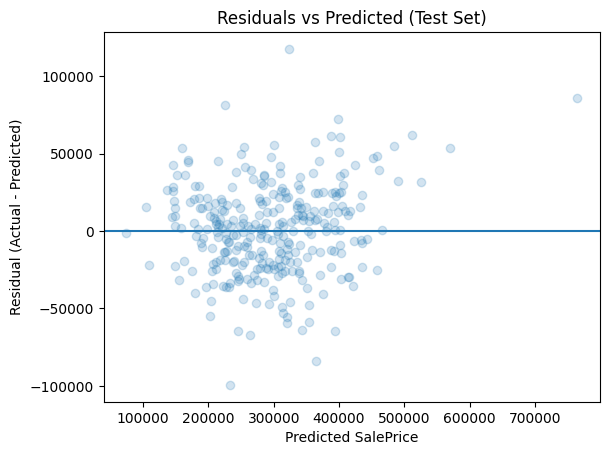

In [13]:
# Session 3 — Code Cell 13 (Optional but recommended)
# Residual analysis: where does the model make mistakes?
# Residual = actual - predicted
# Patterns in residuals often reveal missing features, non-linearity, or outliers.

import matplotlib.pyplot as plt

residuals = y_test - y_pred_test

plt.figure()
plt.scatter(y_pred_test, residuals, alpha=0.2)
plt.axhline(0)
plt.title("Residuals vs Predicted (Test Set)")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

# What to look for:
# - Random cloud around 0 is good
# - Curves/patterns suggest non-linearity
# - Funnel shape suggests heteroscedasticity (variance changes with price)


### What is this plot showing?

This plot compares:
- **Predicted SalePrice** (x-axis)
- **Residual = Actual − Predicted** (y-axis)

A **residual** is simply:
> “How wrong was the model for this house?”

- Residual = 0 → perfect prediction
- Positive residual → model predicted too low
- Negative residual → model predicted too high

The horizontal line at 0 represents **perfect predictions**.

---

### What would an ideal plot look like?

In an ideal world:
- Points are randomly scattered around 0
- No visible pattern
- Similar spread across all price ranges

This would mean:
- The model is not systematically biased
- Errors are mostly random noise

---

### What do we actually see here?

What’s good:
- Points are roughly centered around 0  
- No strong curve or obvious pattern
- Errors are similar for most price ranges

This suggests:
- The model has learned the main relationships
- No obvious systematic bias (e.g. always underpricing expensive houses)

---

### What imperfections can we still see?

1. **Large residuals**
   - Some predictions are off by ±100,000
   - These are the same “hard” houses we saw earlier

2. **Slightly wider spread at higher prices**
   - Expensive houses tend to have more uncertainty
   - This is normal in real estate data

3. **Outliers**
   - A few houses behave very differently from the rest
   - These often need special handling or more features

---

### What does this imply about the model?

This plot tells us:
- The model is **not overfitting**
- The model is **not obviously biased**
- Errors appear mostly random

However:
- The model struggles with extreme or unusual houses
- Linear regression cannot capture all complexity

---

### Key lesson (very important)

Metrics like MAE and R² tell you **how good** the model is.  
Residual plots tell you **how the model fails**.

Good data scientists always look at both.

If residuals show patterns:
- The problem is usually the data or assumptions
- Not “we need a bigger model”


In [14]:
# Session 3 — Code Cell 14 (Optional quick check)
# Inspect the worst errors (helps you teach outliers + data issues)

errors = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_test,
    "AbsError": np.abs(y_test.values - y_pred_test)
})

errors_sorted = errors.sort_values("AbsError", ascending=False)
print(errors_sorted.head(10))  # Top 10 worst errors

     Actual      Predicted       AbsError
299  441730  324164.571219  117565.428781
82   134200  233565.151035   99365.151035
173  850000  764392.869477   85607.130523
8    280900  364844.911254   83944.911254
118  307160  225610.778776   81549.221224
175  470420  398013.643732   72406.356268
46   196300  263432.702594   67132.702594
57   329260  393665.615156   64405.615156
63   180330  244577.691461   64247.691461
48   279890  343488.970906   63598.970906


In [15]:
# Session 3 — Code Cell 15 (Optional: tie errors back to original rows)
# Join worst-error rows back to their original features for investigation.

worst_idx = errors_sorted.head(5).index  # indices in y_test (not original df index if split shuffled)
worst_rows = X_test.iloc[worst_idx].copy()
worst_rows["ActualSalePrice"] = y_test.iloc[worst_idx].values
worst_rows["PredictedSalePrice"] = y_pred_test[worst_idx]
worst_rows["AbsError"] = errors_sorted.head(5)["AbsError"].values

print(worst_rows)


        Id Neighborhood  YearBuilt  LotArea  OverallQual  GrLivArea  FullBath  \
824    825      Somerst       2003   6820.0            7       1729         2   
240    241      Crawfor       1980   4141.0            2        936         1   
700    701      CollgCr       1975   4739.0            6       5958         4   
1272  1273      Edwards       1964   5846.0           10       2364         2   
115    116        NAmes       1962   5737.0            6        869         2   

      GarageCars  Fireplaces CentralAir KitchenQual  DistanceToCityCenterKm  \
824          1.0           2          Y         NaN                   16.40   
240          0.0           1          Y          Ex                    8.39   
700          1.0           1          Y          Gd                    8.04   
1272         3.0           2          N          Fa                    7.90   
115          1.0           2          Y          TA                    7.10   

     SaleCondition  ActualSalePrice  P

In [16]:
# Relative error (%) for test predictions
relative_error_pct = np.abs(y_test.values - y_pred_test) / y_test.values * 100

rel_error_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_test,
    "RelativeErrorPct": relative_error_pct
})

# Show worst relative errors
rel_error_df.sort_values("RelativeErrorPct", ascending=False).head(10)

,Actual,Predicted,RelativeErrorPct
82,134200,233565.151035,74.042586
162,148010,202953.448529,37.121444
63,180330,244577.691461,35.627844
46,196300,263432.702594,34.199033
8,280900,364844.911254,29.884269
119,158130,203596.691481,28.752730
264,139110,178904.077349,28.606195
299,441730,324164.571219,26.614771
118,307160,225610.778776,26.549427
214,122500,154434.644820,26.069098


### Why look at relative error (%)

Relative error tells us **how bad a mistake is relative to the house price**.

Examples:
- 10% error → usually acceptable
- 20–30% error → concerning
- 40%+ error → model failed badly

This is often more meaningful than absolute error,
especially when prices vary a lot.

Key idea:
> Absolute error shows size.  
> Relative error shows severity.


### Why look at the worst errors?

Average metrics hide important failures.

By looking at the **largest mistakes**, we learn:
- Where the model struggles
- Which types of houses are risky to predict

---

### What do we see here?

These rows show houses where predictions were off by:
- 60,000 to over 100,000

This is not random noise.

---

### Why do these big errors happen?

Common reasons:
- Luxury or unusual houses
- Rare combinations of features
- Important missing features (renovations, exact location)
- Non-linear effects the model cannot capture

Key lesson:
> Models fail first on edge cases.  
> That’s where business risk lives.


### What are we doing here?

We take the worst prediction errors
and look at the **actual house features** that caused them.

This connects model errors back to real data.

---

### What patterns should we look for?

Ask:
- Is the house unusually large or small?
- Is the quality extreme?
- Is something missing or odd?
- Does the price seem unusually high or low for its features?

Example observations:
- Very large living areas
- High quality but poor prediction
- Missing kitchen quality values
- Houses that don’t follow typical patterns

---

### Why this matters

This step shows an important truth:

> Models don’t fail randomly.  
> They fail for understandable reasons.

Understanding failures is more important than improving metrics.


### We found problems. What do we do about them?

Finding issues (worst rows, high R², large residuals) is not failure.
It is the **expected outcome** of a good analysis.

The mistake beginners make is jumping to:
> “Use a more complex model.”

That is often the **wrong first move**.

---

## Case 1: Very High R² (≈ 0.91)

### What this usually means
A high R² can happen because:
- The data has strong, clean patterns
- The relationships are mostly linear
- The dataset is synthetic or simplified
- Important leakage-prone features exist

High R² does **not** automatically mean:
- The model is realistic
- The model will work in production
- The model understands the real world

---

### What should we do?

**Step 1 — Question the data**
Ask:
- Was this data generated or collected?
- Are relationships “too clean”?
- Are we missing real-world messiness (renovations, market shocks)?

**Step 2 — Validate assumptions**
- Does it make sense that size + quality explain most of the price?
- Are there real factors not present (school rating, crime, view)?

**Step 3 — Don’t celebrate yet**
High R² is a signal to be *suspicious*, not excited.

Rule:
> High R² means “double-check assumptions,” not “ship the model.”

---

## Case 2: Worst Rows (Large Errors)

### What worst rows actually represent

Worst rows are usually:
- Unusual houses (luxury, very small, very old)
- Rare feature combinations
- Missing or weakly represented features
- Data quality issues

They are not “random mistakes”.

---

### What should we do?

**Step 1 — Categorize the failure**
For each worst row, ask:
- Is this house unusual?
- Is it missing important info?
- Is it outside the model’s comfort zone?

**Step 2 — Decide if it matters**
Ask a business question:
- Do we care about predicting these cases?
- Are these high-risk or low-volume cases?

Sometimes the correct decision is:
> “We accept poor performance here.”

**Step 3 — Improve data, not the model**
Before changing models, try:
- Better features (e.g. price per sqft, age of house)
- Feature interactions (age × quality)
- Domain-driven transformations

Rule:
> Fix data and features before changing algorithms.

---

## Case 3: Large Errors at High Prices

### Why this happens
- Expensive houses are more diverse
- Price drivers become more subjective
- Linear assumptions break down

This is normal.

---

### What should we do?

Options (in order):

1. **Segment the problem**
   - One model for “normal” houses
   - One model for luxury houses

2. **Transform the target**
   - Predict log(price) instead of price
   - Reduces impact of extreme values

3. **Accept uncertainty**
   - Some markets are inherently noisy

Do NOT immediately:
- Add deep learning
- Add hundreds of features
- Tune hyperparameters blindly

---

## The Correct Mental Model (Very Important)

When you see:
- High R²
- Large residuals
- Worst rows

You are not supposed to think:
> “My model is bad.”

You are supposed to think:
> “What assumptions did I make, and where do they break?”

---

## Summary Rules to Teach

- High R² → be suspicious, not confident
- Worst rows → learning opportunity, not embarrassment
- Fix data and features before models
- Models fail first on edge cases — that’s normal
- Good modeling is iterative, not heroic

If your reaction is always “try a better model”,
you skipped the thinking step.


In [17]:
# Train the same model, but on log(price)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

model_log = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

model_log.fit(X_train, y_train_log)

# Predict log(price) and convert back
y_pred_log = model_log.predict(X_test)
y_pred_log_exp = np.exp(y_pred_log)


In [18]:
regression_metrics(y_test, y_pred_log_exp, label="Linear Regression (Log Price)")


--- Linear Regression (Log Price) ---
MAE: 24,692
MSE: 1,628,439,915
R² : 0.8286


{'MAE': 24692.0298058252, 'MSE': 1628439914.9801853, 'R2': 0.8286124512213318}